## Load the data
## Modelling (BaseLine)
## Modelling (Testing)
## Modelling (Final)

In [1]:
import os
import cv2
import torch
import numpy as np

In [2]:
BATCH_SIZE = 32

In [3]:
from tqdm import tqdm

In [4]:
def load_data(img_size=112):
    data = []
    index = -1
    labels = {}
    for directory in os.listdir('./data/')[:37]:
        index += 1
        labels[f'./data/{directory}/'] = [index,-1]
    for label in tqdm(labels):
        for file in os.listdir(label):
            filepath = label + file
            img = cv2.imread(filepath)
            img = cv2.resize(img,(img_size,img_size))
#             img = img / 255.0
            data.append([
                np.array(img),
                labels[label][0]
            ])
            labels[label][1] += 1
    for _ in range(12):
        np.random.shuffle(data)
    print(len(data))
#     np.save('./data.npy',data)
    return data

In [5]:
import torch

In [6]:
def other_loading_data_proccess(data):
    print(len(data))
    X = []
    y = []
    print('going through the data..')
    for d in data:
        X.append(d[0])
        y.append(d[1])
    print('splitting the data')
    VAL_SPLIT = 0.25
    VAL_SPLIT = len(X)*VAL_SPLIT
    VAL_SPLIT = int(VAL_SPLIT)
    X_train = X[:-VAL_SPLIT]
    y_train = y[:-VAL_SPLIT]
    X_test = X[-VAL_SPLIT:]
    y_test = y[-VAL_SPLIT:]
    print('turning data to tensors')
    X_train = torch.from_numpy(np.array(X_train))
    print(len(X_train))
    y_train = torch.from_numpy(np.array(y_train))
    print(len(y_train))
    X_test = torch.from_numpy(np.array(X_test))
    print(len(X_test))
    y_test = torch.from_numpy(np.array(y_test))
    print(len(y_test))
    return [X_train,X_test,y_train,y_test]

In [7]:
REBUILD_DATA = True
if REBUILD_DATA:
    data = load_data()
    np.random.shuffle(data)
    X_train,X_test,y_train,y_test = other_loading_data_proccess(data)

100%|██████████| 37/37 [00:03<00:00, 10.27it/s]


18895
18895
going through the data..
splitting the data
turning data to tensors
14172
14172
4723
4723


In [8]:
import torch
import torch.nn as nn
from torchvision import transforms

In [9]:
import matplotlib.pyplot as plt

In [10]:
transform_train = transforms.Compose([
    transforms.RandomCrop(112, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(112),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.25,0.25),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [11]:
from PIL import Image

In [12]:
X_train_new = []

In [13]:
import random

In [14]:
for index in range(len(X_train)):
    testing = X_train[index]
    testing = np.array(testing)
    testing = Image.fromarray(testing)
    X_train_new.append(np.array(transform_train(testing)))

In [15]:
X_train_new = np.array(X_train_new)

In [16]:
X_train_new = X_train_new.astype(int)

In [17]:
X_train = torch.from_numpy(X_train_new)

In [18]:
X_train.shape

torch.Size([14172, 3, 112, 112])

## Modelling BaseLine

In [19]:
import torch
import torch.nn as nn

In [20]:
from torchvision import models

In [21]:
device = torch.device('cuda')

In [23]:
model = models.resnet18(pretrained=True).to(device)
model = model.to(device)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 37)
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
criterion = nn.CrossEntropyLoss()

In [25]:
EPOCHS = 12

In [26]:
BATCH_SIZE = 32

In [27]:
from tqdm import tqdm

In [28]:
loss_logs = []

In [29]:
for _ in tqdm(range(EPOCHS)):
    for i in range(0,len(X_train),BATCH_SIZE):
        X_batch = X_train[i:i+BATCH_SIZE].view(-1,3,112,112).to(device)
        y_batch = y_train[i:i+BATCH_SIZE].to(device)
        model = model.to(device)
        preds = model(X_batch.float().to(device))
        preds = preds.to(device)
        loss = criterion(preds,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_logs.append(loss.item())

100%|██████████| 12/12 [02:10<00:00, 10.88s/it]


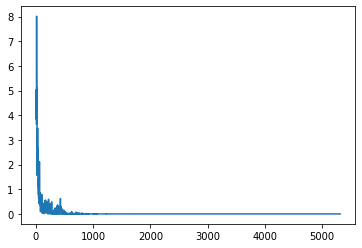

In [30]:
plt.plot(loss_logs)

In [31]:
y_batch.shape

torch.Size([28])

In [54]:
preds.shape

torch.Size([28, 37])

In [55]:
preds_new = []

In [56]:
for pred in preds:
    preds_new.append(int(torch.argmax(torch.round(pred))))

In [57]:
def get_loss(criterion,y,model,X):
    model.to('cpu')
    preds = model(X.view(-1,1,112,112).to('cpu').float())
    preds.to('cpu')
    loss = criterion(preds,torch.tensor(y,dtype=torch.long).to('cpu'))
    loss.backward()
    return loss.item()

In [58]:
def test(net,X,y):
    device = 'cpu'
    net.to(device)
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for i in range(len(X)):
            real_class = torch.argmax(y[i]).to(device)
            net_out = net(X[i].view(-1,1,112,112).to(device).float())
            net_out = net_out[0]
            predictied_class = torch.argmax(net_out)
            if predictied_class == real_class:
                correct += 1
            total += 1
    net.train()
    net.to('cuda')
    return round(correct/total,3)

In [59]:
PROJECT_NAME = 'fruits-37'

In [61]:
import wandb

In [ ]:
optimizers = [torch.optim.Adam,torch.optim.AdamW,torch.optim.Adamax,torch.optim.SGD]
for optimizer in optimizers:
    model = models.resnet18(pretrained=True).to(device)
    model = model.to(device)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 37)
    optimizer = optimizer(model.parameters(),lr=0.1)
    criterion = nn.CrossEntropyLoss()
    wandb.init(project=PROJECT_NAME,name=f'optimizer-{optimizer}')
    for _ in tqdm(range(EPOCHS)):
        for i in range(0,len(X_train),BATCH_SIZE):
            X_batch = X_train[i:i+BATCH_SIZE].view(-1,3,112,112).to(device)
            y_batch = y_train[i:i+BATCH_SIZE].to(device)
            model = model.to(device)
            preds = model(X_batch.float().to(device))
            preds = preds.to(device)
            loss = criterion(preds,y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        wandb.log({'loss':loss.item(),'accuracy':test(model,X_train,y_train),'val_accuracy':test(model,X_test,y_test),'val_loss':get_loss(criterion,y_test,model,X_test)})

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)


  0%|          | 0/12 [00:00<?, ?it/s]